In [153]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline

In [154]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [155]:
def generate_matrix(type: str, sparse: bool, size: int, min_val: float, max_val: float, grouping_factor: float = 0, density: float = 1) -> np.array:
  """Generates various types of REAL matrices with controlled value range and diagonal grouping.

  Args:
    type: The type of matrix to generate.
          Options: 'nonsymmetric', 'symmetric', 'normal', 'orthogonal'.
    sparse: Whether to generate a sparse matrix.
    size: The size of the matrix (size x size).
    min_val: Minimum value of the matrix elements.
    max_val: Maximum value of the matrix elements.
    grouping_factor: Controls the strength of diagonal grouping. 
                     0: No grouping.
                     Positive values: Increase grouping strength.

  Returns:
    A NumPy array representing the generated matrix.
  """
  
  seed = 42
  np.random.seed(seed)
  
  if type == 'nonsymmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr').toarray()
    else:
      A = np.random.rand(size, size)
    if grouping_factor > 0:
      for i in range(size):
        A[i, :] = A[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
    return A * (max_val - min_val) + min_val

  elif type == 'symmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr')
      A = (A + A.transpose()).toarray() / 2
    else:
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
    if grouping_factor > 0:
      for i in range(size):
        for j in range(size):
          A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
    return A * (max_val - min_val) + min_val

  elif type == 'normal':
    if sparse:
      raise ValueError("Sparse normal matrices are not well-defined.")
    else:
      # Generate a symmetric matrix (guaranteed to be normal)
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
      if grouping_factor > 0:
        for i in range(size):
          for j in range(size):
            A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
      return A * (max_val - min_val) + min_val

  elif type == 'orthogonal':
    if sparse:
      raise ValueError("Sparse orthogonal matrices are not well-defined.")
    else:
      Q, _ = np.linalg.qr(np.random.rand(size, size))
      if grouping_factor > 0:
        for i in range(size):
          Q[i, :] = Q[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
      return Q * (max_val - min_val) + min_val

  else:
    raise ValueError(f"Invalid matrix type: {type}")

In [174]:
nonsymmetric_matrix_sparse = generate_matrix('nonsymmetric', True, 100, 100, 1000,density=0.05)
nonsymmetric_matrix_bottom_group = generate_matrix('nonsymmetric', False, 100, 100, 1000,grouping_factor=1000)
symmetric_matrix = generate_matrix('symmetric', False, 100, 0, 10)
symmetric_matrix_diag = generate_matrix('symmetric', False, 100, 0, 10,grouping_factor=5)
orthogonal_matrix = generate_matrix('orthogonal', False, 100, 0, 1)
symmetric_matrix_diag_sparse = generate_matrix('symmetric', True, 250, 0, 1000,grouping_factor=3,density=0.3)
symmetric_matrix_small = generate_matrix('symmetric', False, 25, 0, 1)

matrix_dict = {
    1 : [nonsymmetric_matrix_sparse, "nonsym_sparse"],
    2 : [nonsymmetric_matrix_bottom_group, "nonsym_bottom_group"],
    3 : [symmetric_matrix,"sym"],
    4 : [symmetric_matrix_diag, "sym_diag"],
    5 : [orthogonal_matrix, "orthogonal"],
    6 : [symmetric_matrix_diag_sparse, "sym_diag_sparse"],
    7 : [symmetric_matrix_small, "sym_small"],
}

In [157]:
def testing(my_function, A: np.array, name: str,show_plots: bool=False, function_name: str="My_func"):
  """Compares your eigenvalue algorithm with NumPy's eigvals.

  Args:
    my_function: function that takes a NumPy array (matrix) and returns a NumPy array of eigenvalues.
    A: The input matrix for eigenvalue calculation.
  """


  start_time = time.time()
  A_k = A.copy()
  for k in range(100):
      Q,R = my_function(A_k)
      A_k = R @ Q
  my_eigenvalues = np.array(np.diag(A_k))
  my_time = time.time() - start_time

  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time

  my_eigenvalues.sort()
  numpy_eigenvalues.sort()

  # Accuracy
  
  errors = np.abs(numpy_eigenvalues - my_eigenvalues) / np.abs(numpy_eigenvalues)
  max_error = np.max(errors)
  avg_error = np.mean(errors)
  median_error = np.median(errors)
  # print("----------")
  # print(f'{name}:')
  #print("  Time:", my_time, "seconds")
  # print("NumPy eigvals:")
  # print("  Time:", numpy_time, "seconds")
  # print("\nAccuracy:")
  # print("  Maximum Error:", max_error)
  # print("  Average Error:", avg_error)
  # print("  Median Error:", median_error)
  # print("----------\n")
  
  if(show_plots):
    # Plot the differences
    my_eigenvalues_abs = np.abs(my_eigenvalues)
    numpy_eigenvalues_abs = np.abs(numpy_eigenvalues)
    plt.figure(figsize=(8, 6))
    plt.plot(my_eigenvalues_abs, label=str(function_name + ' abs'))
    plt.plot(numpy_eigenvalues_abs, label="NumPy eigvals abs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    # Plot the errors
    plt.figure(figsize=(8, 6))
    plt.plot(errors)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Absolute Error")
    plt.title("Eigenvalue Error $ \dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")
    plt.show()
    
  return np.array([max_error,avg_error,median_error,my_time])

<>:58: SyntaxWarning: invalid escape sequence '\d'
<>:58: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_30280/1310281370.py:58: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Eigenvalue Error $\dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")


In [158]:
def test_all(matrix_dict: dict, my_function,show_plots: bool=False,skip_matrices_id: list=[], function_name: str="My_function"):
    errors_by_function = np.zeros((len(matrix_dict),4))
    for matrix_id,items in matrix_dict.items():
        if(matrix_id in skip_matrices_id): continue
        name = items[1]
        matrix = items[0]
        errors_by_matrix = testing(my_function=my_function,A=matrix,name=name,show_plots=show_plots, function_name=function_name)
        #print(errors_by_matrix)
        errors_by_function[matrix_id - 1 - len(skip_matrices_id)] = errors_by_matrix
        if(show_plots):
            plot_2d_temperature(matrix=matrix,title=name)
    return errors_by_function

In [159]:
def qr_pershin(A: NDArrayFloat) -> tuple[NDArrayFloat, NDArrayFloat]: # на выходе Q и R
    n = A.shape[0]
    Q = np.zeros_like(A)
    R = np.zeros_like(A)
    W = A.copy()
    
    for j in range(n):
        w_j_norm = np.linalg.norm(W[: , j])
        Q[: , j ] = W[: , j] / w_j_norm # W[: , j] == w_j^j
        for i in range(j):
            R[i,j] = A[: , j] @ Q[:, i]
        a_j_norm = np.linalg.norm(A[:, j])
        R[j,j] = np.sqrt(np.abs(a_j_norm**2 - np.sum(R[ :j , j] ** 2)))
        for k in range(j+1,n):
            prod = W[: , k] @ Q[: , j]
            W[:, k ] = W[: , k] - prod * Q[:, j]
    return Q,R

In [160]:
def Gram_Schmidt_optimised_QR(A: np.array):
    """
    Optimized Gram-Schmidt process with normalization.
    The coefficients q will be calculated at each step of the algorithm.
    Each time we will subtract the component of the vector from all the vectors q at once.
    """
    m, n = A.shape  # Get both dimensions of A
    Q = A.copy()
    R = np.zeros((n, n))  # Initialize R with zeros

    for k in range(n): # Orthogonalize the k-th column
        R[k, k] = np.linalg.norm(Q[:, k]) # Normalize the k-th column
        Q[:, k] /= R[k, k] 
        for j in range(k + 1, n): # Subtract the projection from subsequent columns 
            R[k, j] = np.dot(Q[:, k], Q[:, j])
            Q[:, j] -= R[k, j] * Q[:, k] 
    return Q, R

In [161]:
def basic_QR(A: np.array):
    """
    Basic Gram-Schmidt process with normalization.
    """
    n = A.shape[0]
    Q, R = np.eye(n), np.eye(n)
    
    for k in range(n):
        u_k = A[:, k].copy()
        for j in range(k):
            coef = np.dot(u_k, Q[:, j])
            R[j, k] = coef
            u_k -= coef * Q[:, j] # update u_k
        norm_u_k = np.linalg.norm(u_k)
        u_k /= norm_u_k
        Q[:, k] = u_k
    return Q, R 

In [162]:
def qr_householder(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    QR decomposition using Householder reflections.
    """
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)

    for k in range(min(m - 1, n)):
        x = R[k:, k]
        e1 = np.zeros(len(x))
        e1[0] = 1
        v = x - np.linalg.norm(x) * e1  # Calculate the Householder vector
        H_k = np.eye(m)
        H_k[k:, k:] = np.eye(len(x)) - 2 * np.outer(v, v) / np.dot(v, v) # Embed the reflection 
        Q = Q @ H_k
        R = H_k @ R

    return Q, R

In [163]:
def qr_givens(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    QR decomposition using Givens rotations.
    """

    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()

    for j in range(n):
        for i in range(m-1, j, -1):
            # Calculate Givens rotation parameters (embedded directly)
            a = R[i-1, j]
            b = R[i, j]

            if b == 0:
              c = 1
              s = 0
            else:
              if abs(b) > abs(a):
                r = a / b
                s = 1 / np.sqrt(1 + r**2)
                c = r * s
              else:
                r = b / a
                c = 1 / np.sqrt(1 + r**2)
                s = r * c

            G = np.eye(m)
            G[i-1:i+1, i-1:i+1] = [[c, -s], [s, c]]
            R = G @ R
            Q = G @ Q

    return Q.T, R 

In [164]:
functions_dict = {
    1 : [Gram_Schmidt_optimised_QR, "Gram_Schmidt_optimised_QR"],
    2 : [qr_pershin, "QR by Pershin"],
    3 : [basic_QR, "QR basic"],
    4 : [qr_householder, "QR decomposition using Householder reflections."],
    #5 : [qr_givens , "QR decomposition using Givens rotations."]
}

In [165]:
def function_test_all_matrices(function_dict: dict,matrix_dict: dict,show_plots=False):
    list_of_all_median_errors = np.zeros((len(matrix_dict) , len(function_dict)))
    list_of_all_max_errors = np.zeros((len(matrix_dict) , len(function_dict)))
    list_of_all_avg_errors = np.zeros((len(matrix_dict) , len(function_dict)))
    list_of_all_times = np.zeros((len(matrix_dict) , len(function_dict)))
    print(len(function_dict), len(matrix_dict))
    for function_id, items_function in function_dict.items():  # Add .items() here
        func = items_function[0]
        name_of_func = items_function[1]
        print(name_of_func)
        big_data = test_all(matrix_dict=matrix_dict,my_function=func,show_plots=False,function_name=name_of_func)
        
        list_of_all_times[: , function_id - 1] = big_data[: , 3]
        list_of_all_median_errors[: , function_id - 1] = big_data[: , 2]
        list_of_all_max_errors[: , function_id - 1] = big_data[: , 0]
        list_of_all_avg_errors[: , function_id - 1] = big_data[: , 1]
    return np.array([list_of_all_times,list_of_all_median_errors,list_of_all_max_errors,list_of_all_avg_errors])
    

In [166]:
list_of_all_lists = function_test_all_matrices(functions_dict,matrix_dict)

4 7
Gram_Schmidt_optimised_QR
QR by Pershin
QR basic
QR decomposition using Householder reflections.


In [167]:
time_data = list_of_all_lists[0]

0
1
2
3


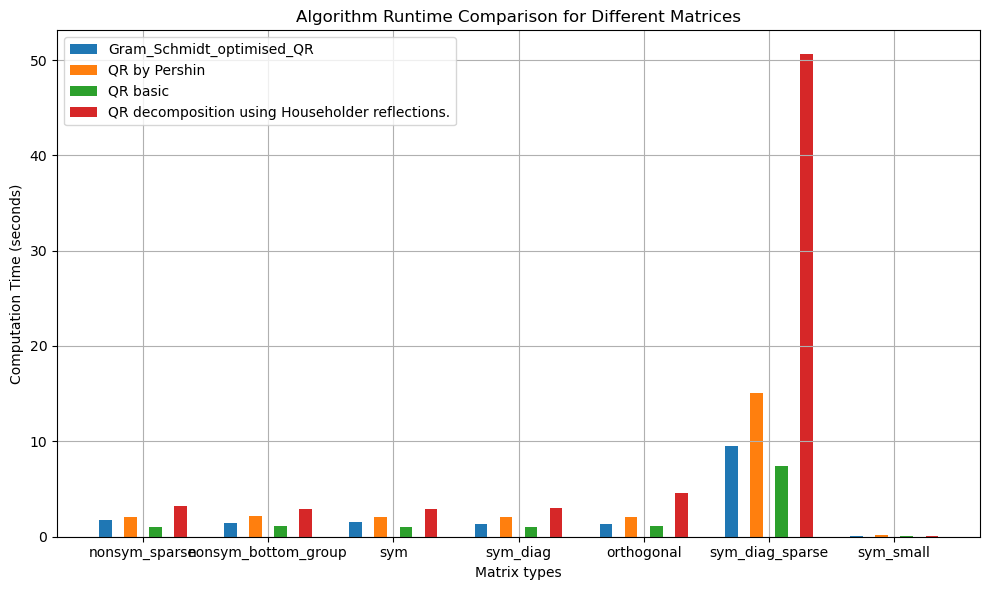

In [175]:
# Extract data for each algorithm
algorithm_times = time_data.T  # Transpose data to have algorithms as rows

# Create the plot
plt.figure(figsize=(10, 6))

# Correct the labels list to include all algorithms
labels = []
for i in functions_dict.items():
    labels.append(i[1][1])

matrix_labels = []
for i in matrix_dict.items():
    matrix_labels.append(i[1][1])


x = np.arange(len(matrix_labels))

for i, algorithm_time in enumerate(algorithm_times):
    print(i)
    plt.bar(x + i * 0.2, algorithm_time, width=0.1, label=labels[i])

plt.xlabel('Matrix types')
plt.ylabel('Computation Time (seconds)')
plt.title('Algorithm Runtime Comparison for Different Matrices')
plt.xticks(x + 0.3, matrix_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

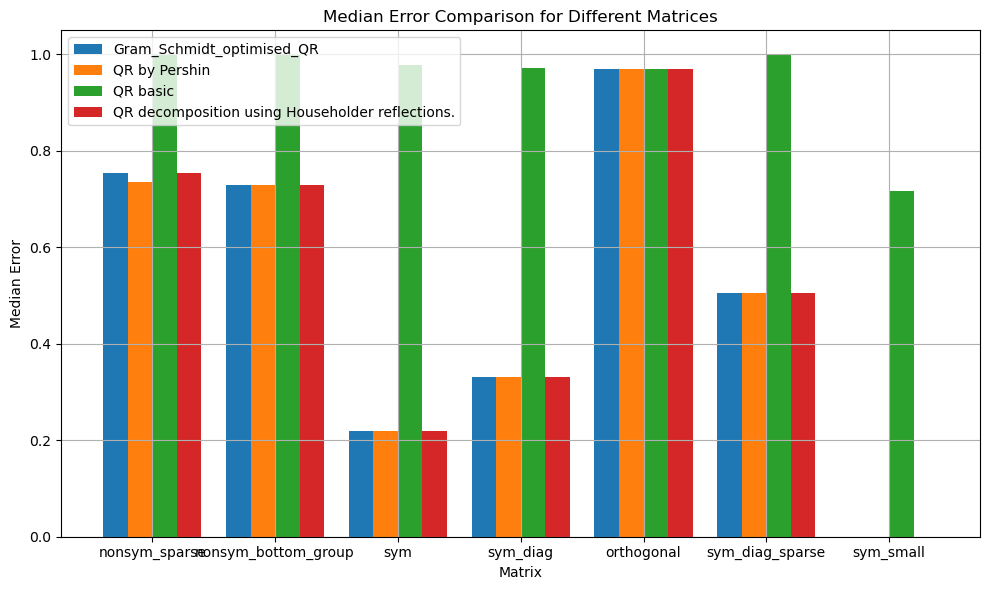

In [185]:
median_error_data = list_of_all_lists[1]
algorithm_median_err = median_error_data.T  

plt.figure(figsize=(10, 6))

labels = [i[1][1] for i in functions_dict.items()]
matrix_labels = [i[1][1] for i in matrix_dict.items()]

x = np.arange(len(matrix_labels))

# Iterate through the *transposed* data
for i, algorithm_med_err in enumerate(algorithm_median_err): 
    plt.bar(x + i * 0.2, algorithm_med_err, width=0.2, label=labels[i])

plt.xlabel('Matrix')
plt.ylabel('Median Error') 
plt.title('Median Error Comparison for Different Matrices')
plt.xticks(x + 0.3, matrix_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

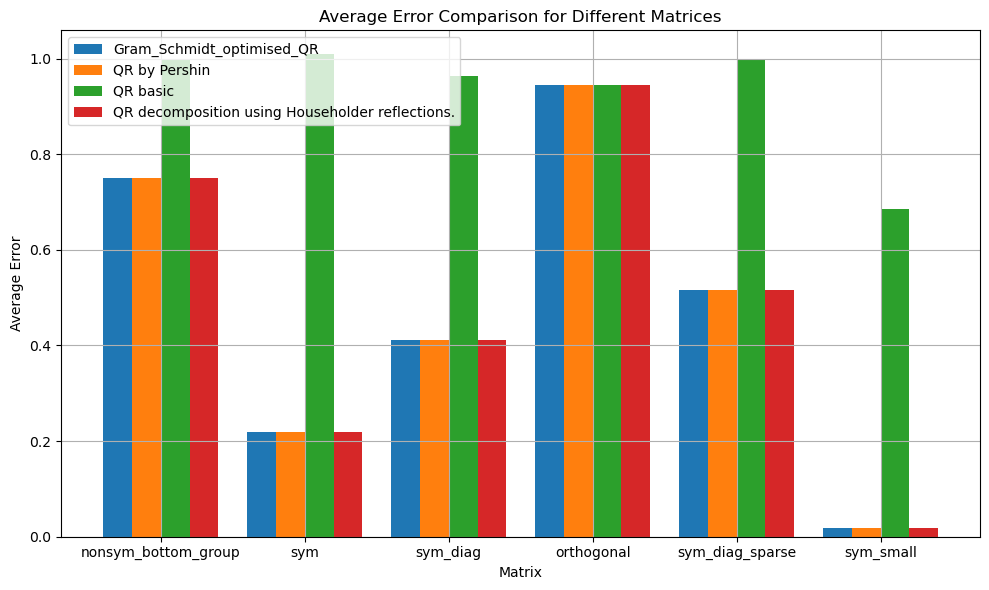

In [192]:
avg_error_data = list_of_all_lists[3]
algorithm_avg_err = avg_error_data.T[: , 1 : ]

plt.figure(figsize=(10, 6))

labels = [i[1][1] for i in functions_dict.items()]
matrix_labels = [i[1][1] for i in matrix_dict.items()]

matrix_labels = matrix_labels[ 1 : ]
x = np.arange(len(matrix_labels))

# Iterate through the *transposed* data
for i, algorithm_avger_err in enumerate(algorithm_avg_err): 
    plt.bar(x + i * 0.2, algorithm_avger_err, width=0.2, label=labels[i])

plt.xlabel('Matrix')
plt.ylabel('Average Error') 
plt.title('Average Error Comparison for Different Matrices')
plt.xticks(x + 0.3, matrix_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()